## Configurations

In [ ]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
TRAIN_IMAGES_DIR = '/content/train_v2/train'
VALID_IMAGES_DIR = '/content/validation_v2/validation'
TEST_IMAGES_DIR = '/content/test_v2/test'
TRAIN_CSV = '/content/written_name_train_v2.csv'
VALID_CSV = '/content/written_name_validation_v2.csv'
TEST_CSV = '/content/written_name_test_v2.csv'
MAX_LENGTH = 20
VOCAB_SIZE = 30
IMAGE_SIZE = [300, 100]

## Utility Functions

In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F


def get_dataset(csv_file, drop_low_samples=True):
    dataset = pd.read_csv(csv_file)
    cleaned_data = dataset.dropna()
    cleaned_data = cleaned_data[cleaned_data['IDENTITY'] != 'UNREADABLE']
    cleaned_data['IDENTITY'] = cleaned_data['IDENTITY'].str.lower()
    cleaned_data = cleaned_data.reset_index(drop=True)
    if drop_low_samples:
        indices = [idx for idx, label in enumerate(
            cleaned_data['IDENTITY'].values) if len(label) > MAX_LENGTH]
        cleaned_data = cleaned_data.drop(index=indices)
        cleaned_data = cleaned_data.reset_index(drop=True)
    return cleaned_data


def get_vocabulary():
    vocabulary = [' ', "'", '-', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                  'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    int2char = dict(enumerate(vocabulary))
    int2char = {k+1: v for k, v in int2char.items()}
    char2int = {v: k for k, v in int2char.items()}

    return int2char, char2int


def encode(string):
    _, char2int = get_vocabulary()
    token = torch.tensor([char2int[i] for i in string])
    pad_token = F.pad(token, pad=(0, MAX_LENGTH-len(token)),
                      mode='constant', value=0)
    return pad_token


def decode(token, vocabulary):
    int2char, _ = get_vocabulary()
    token = token[token != 0]
    string = [int2char[i.item()] for i in token]
    return "".join(string)

## Dataset Class

In [ ]:
import os
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset


class HRDataset(Dataset):
    def __init__(self, dataset, encoder, mode='train'):
        super().__init__()
        if mode == 'train':
            self.dataset_path = TRAIN_IMAGES_DIR
        elif mode == 'valid':
            self.dataset_path = VALID_IMAGES_DIR
        elif mode == 'test':
            self.dataset_path = TEST_IMAGES_DIR

        self.data = dataset
        self.encoder = encoder

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        image_file = self.data.iloc[index]['FILENAME']
        image = cv2.imread(os.path.join(self.dataset_path, image_file),
                           cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, IMAGE_SIZE,
                           interpolation=cv2.INTER_AREA)
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) / 255.

        image = np.expand_dims(image, 0)

        label = self.data.iloc[index]['IDENTITY']
        label = self.encoder(label)

        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.int32)

        return image, label

## Model Definition

In [ ]:
import torch
import torch.nn as nn


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(64)

        self.maxpool = nn.MaxPool2d((2, 2))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

        # 768 -> 12(feature height)*64(feature channel)
        self.fc = nn.Linear(768, 64)

    def forward(self, images):
        outputs = self.maxpool(self.relu(self.bn1(self.conv1(images))))
        outputs = self.maxpool(self.relu(self.bn2(self.conv2(outputs))))
        outputs = self.maxpool(self.relu(self.bn3(self.conv3(outputs))))

        outputs = outputs.permute(0, 2, 3, 1)
        outputs = outputs.reshape(
            outputs.shape[0], -1, outputs.shape[2]*outputs.shape[3])
        outputs = torch.stack([self.relu(self.fc(outputs[i]))
                               for i in range(outputs.shape[0])])
        outputs = self.dropout(outputs)
        return outputs


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True, dropout=0.25)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, labels):
        h0 = torch.zeros(self.num_layers * 2, labels.size(0),
                         self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers * 2, labels.size(0),
                         self.hidden_size).to(DEVICE)

        outputs, _ = self.lstm(labels, (h0, c0))
        outputs = torch.stack([self.fc(outputs[i])
                               for i in range(outputs.shape[0])])
        outputs = self.softmax(outputs)
        return outputs


class CRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CRNN, self).__init__()
        self.RNN = BiLSTM(input_size, hidden_size,
                          output_size, num_layers)
        self.CNN = FeatureExtractor()

    def forward(self, images):
        features = self.CNN(images)
        outputs = self.RNN(features)
        return outputs

## Training Script

In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from itertools import groupby

# Assuming utils, HRDataset, and CRNN are defined or imported from other cells

def train_one_epoch(loader, model, optimizer, criterion, device):
    loop = tqdm(loader)
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(loop):
        batch_size = inputs.shape[0]
        inputs = inputs.to(device)

        y_pred = model(inputs)
        y_pred = y_pred.permute(1, 0, 2)

        input_lengths = torch.IntTensor(batch_size).fill_(37)
        target_lengths = torch.IntTensor([len(t) for t in labels])

        loss = criterion(y_pred.cpu(), labels,
                         input_lengths, target_lengths)
        total_loss += loss.detach().numpy()

        _, max_index = torch.max(y_pred.cpu(), dim=2)

        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].numpy())

            prediction = torch.IntTensor(
                [c for c, _ in groupby(raw_prediction) if c != 0])
            real = torch.IntTensor(
                [c for c, _ in groupby(labels[i]) if c != 0])

            if len(prediction) == len(real) and torch.all(prediction.eq(real)):
                correct += 1
            total += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ratio = correct / total
    print('TEST correct: ', correct, '/', total, ' P:', ratio)
    print("Avg CTC loss:", total_loss/batch_idx)

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def main():
    # Use the configuration variables defined earlier in the notebook
    train_data = get_dataset(TRAIN_CSV)
    valid_data = get_dataset(VALID_CSV)
    test_data = get_dataset(TEST_CSV)

    train_dataset = HRDataset(train_data, encode, mode='train')
    valid_dataset = HRDataset(valid_data, encode, mode='valid')
    test_dataset = HRDataset(test_data, encode, mode='test')

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(
        valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

    input_size = 64
    hidden_size = 128
    output_size = VOCAB_SIZE + 1
    num_layers = 2

    model = CRNN(input_size, hidden_size, output_size, num_layers)
    model.to(DEVICE)

    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        train_one_epoch(train_loader, model, optimizer, criterion, DEVICE)

    # Save the trained model
    save_model(model, '/content/crnn_model.pth')


if __name__ == "__main__":
    main()

100%|██████████| 2581/2581 [10:55<00:00,  3.93it/s]


TEST correct:  26 / 330274  P: 7.872251524491785e-05
Avg CTC loss: 0.5545997249872185


100%|██████████| 2581/2581 [10:56<00:00,  3.93it/s]


TEST correct:  1670 / 330274  P: 0.005056407709962032
Avg CTC loss: 0.3116873029301795


100%|██████████| 2581/2581 [10:55<00:00,  3.94it/s]


TEST correct:  14404 / 330274  P: 0.04361227344568449
Avg CTC loss: 0.11133863449136387


100%|██████████| 2581/2581 [10:54<00:00,  3.94it/s]


TEST correct:  45308 / 330274  P: 0.13718306618141302
Avg CTC loss: -0.035647907011867895


100%|██████████| 2581/2581 [10:58<00:00,  3.92it/s]


TEST correct:  85034 / 330274  P: 0.2574650138975517
Avg CTC loss: -0.13975372357626062


100%|██████████| 2581/2581 [10:55<00:00,  3.94it/s]


TEST correct:  113711 / 330274  P: 0.34429292042364823
Avg CTC loss: -0.20733233307914217


100%|██████████| 2581/2581 [10:56<00:00,  3.93it/s]


TEST correct:  132755 / 330274  P: 0.4019541350515027
Avg CTC loss: -0.2516345434612775


 51%|█████     | 1313/2581 [05:30<05:03,  4.18it/s]

## Implementation

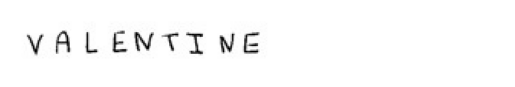

Predicted Text: valentine


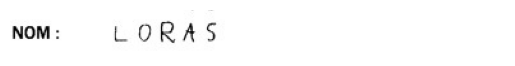

Predicted Text: loras


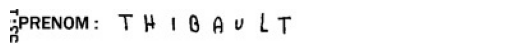

Predicted Text: thibaltt


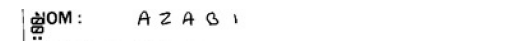

Predicted Text: azabi


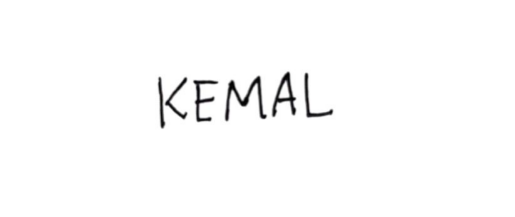

Predicted Text: keeeaal


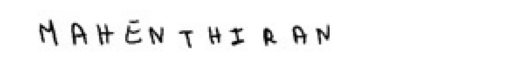

Predicted Text: mahenthiran


In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = [300, 100]

# Function to load the trained model
def load_model(model_path, input_size, hidden_size, output_size, num_layers):
    model = CRNN(input_size, hidden_size, output_size, num_layers)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()  # Set the model to evaluation mode
    return model

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) / 255.
    image = np.expand_dims(image, 0)
    image = torch.as_tensor(image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    return image

# Function to perform inference
def infer_image(model, image_path):
    image = preprocess_image(image_path).to(DEVICE)
    with torch.no_grad():
        prediction = model(image)
        prediction = prediction.permute(1, 0, 2)
        _, max_index = torch.max(prediction, dim=2)

        # Decode the prediction
        prediction = max_index.squeeze(1).cpu()
        result = decode(prediction, get_vocabulary()[0])

    return result

# Function to display the image
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # Load the trained model
    model_path = '/content/crnn_model.pth'
    input_size = 64
    hidden_size = 128
    output_size = VOCAB_SIZE + 1
    num_layers = 2

    model = load_model(model_path, input_size, hidden_size, output_size, num_layers)

    # Directory containing the test images
    test_images_dir = '/mnt/data/'  # Replace with your test images directory

    # List of image filenames to test
    test_images = ['/content/test_v2/test/TEST_0007.jpg', '/content/test_v2/test/TEST_0008.jpg',
                   '/content/test_v2/test/TEST_0009.jpg', '/content/test_v2/test/TEST_0010.jpg',
                   '/content/one.jpg', '/content/test_v2/test/TEST_0012.jpg']
                   # Replace with your image filenames

    for image_filename in test_images:
        image_path = os.path.join(test_images_dir, image_filename)

        # Display the image
        display_image(image_path)

        # Perform inference
        prediction = infer_image(model, image_path)

        print(f"Predicted Text: {prediction}")
